# IMAGINE tutorial 4 --  data masking

### Or how to mask the datasets easily.  

For users who do not want to simulate and fit a full sky map (e.g., to remove confusing regions) or who need patches of a HEALPix map at high resolution, IMAGINE has a Masks class derived from **ObservableDict**.  **hammurabiX** provides galactic longitude/latitude limit controllers, but the Masks class is more flexible.  It also applies the masks correctly not only to the simulation but also the measured data sets and the corresponding observational covariances.  

In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import healpy as hp

from imagine import Measurements, Simulations, Covariances, Masks
from imagine import Hammurabi
from imagine import BregLSA
from imagine import CREAna
from imagine import TEregYMW16

First of all, make an example, let's mask out low latitude ($ |l| < 20^\circ $) pixels and those inside four local loops

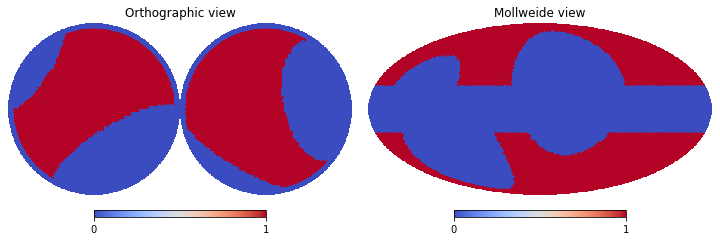

In [2]:
mask_nside = 32

# mask loops and latitude
def mask_map_val(_nside,_ipix):
    l,b = hp.pix2ang(_nside,_ipix,lonlat=True)
    R = np.pi/180.
    cue = 1
    L = [329,100,124,315]
    B = [17.5,-32.5,15.5,48.5]
    D = [116,91,65,39.5]
    #LOOP I
    if( np.arccos(np.sin(b*R)*np.sin(B[0]*R)+np.cos(b*R)*np.cos(B[0]*R)*np.cos(l*R-L[0]*R))<0.5*D[0]*R ):
        cue = 0
    #LOOP II
    if( np.arccos(np.sin(b*R)*np.sin(B[1]*R)+np.cos(b*R)*np.cos(B[1]*R)*np.cos(l*R-L[1]*R))<0.5*D[1]*R ):
        cue = 0
    #LOOP III
    if( np.arccos(np.sin(b*R)*np.sin(B[2]*R)+np.cos(b*R)*np.cos(B[2]*R)*np.cos(l*R-L[2]*R))<0.5*D[2]*R ):
        cue = 0
    #LOOP IV
    if( np.arccos(np.sin(b*R)*np.sin(B[3]*R)+np.cos(b*R)*np.cos(B[3]*R)*np.cos(l*R-L[3]*R))<0.5*D[3]*R ):
        cue = 0
    #STRIPE
    if(abs(b)<20.):
        cue = 0
    return cue

mask_map = np.zeros(hp.nside2npix(mask_nside))

for i in range(len(mask_map)):
    mask_map[i] = mask_map_val(mask_nside, i)

matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
hp.orthview(mask_map, cmap='coolwarm', rot=(0,90), sub=(1,2,1))
hp.mollview(mask_map, cmap='coolwarm', sub=(1,2,2))

As **Masks** is derived from **ObservableDict**, its object creation is the same as **Measurements**

In [3]:
msk_dict = Masks()

msk_dict.append(('sync', '23', '32', 'I'), np.vstack([mask_map]))

**Masks** object, or the mask map dictionary is invoked in **Likelihood** initialisation

where input **Measurements** and **Covariances** objects will be manipulated

then in **Pipeline**, **Simulations** objects produced by a **Simulator** object will be processed in the same way

here we illustrate what actually happens to observables

fist, we need an observable dictionary

In [4]:
# empty measuremnts
arr32 = np.zeros((1, 12*32**2))
arr16 = np.zeros((1, 12*16**2))
arr8 = np.zeros((1, 12*8**2))
measuredict = Measurements()
measuredict.append(('sync', '23', '32', 'I'), arr32)  # healpix map
measuredict.append(('fd', 'nan', '16', 'nan'), arr16)
measuredict.append(('dm', 'nan', '8', 'nan'), arr8)
# consider only init, hammurabi executable is not necessary
xmlpath = './template.xml'
simer = Hammurabi(measurements=measuredict,xml_path=xmlpath)

# ensemble size
ensemble_size = 1

# BregWMAP field
paramlist = {'b0': 6.0, 'psi0': 27.9, 'psi1': 1.3, 'chi0': 24.6}
breg_lsa = BregLSA(paramlist, ensemble_size)
# CREAna field
paramlist = {'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
             'r0': 5.6, 'z0': 1.2,
             'E0': 20.5,
             'j0': 0.03}
cre_ana = CREAna(paramlist, ensemble_size)
# FEregYMW16 field
paramlist = dict()
tereg_ymw16 = TEregYMW16(paramlist, ensemble_size)

# push fields to simulator
simer.register_fields([breg_lsa, cre_ana, tereg_ymw16])

maps = simer([breg_lsa, cre_ana, tereg_ymw16])

print (maps.keys())

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '32'}
|-->  faraday {'cue': '1', 'nside': '16'}
|-->  dm {'cue': '1', 'nside': '8'}
dict_keys([('sync', '23', '32', 'I'), ('fd', 'nan', '16', 'nan'), ('dm', 'nan', '8', 'nan')])


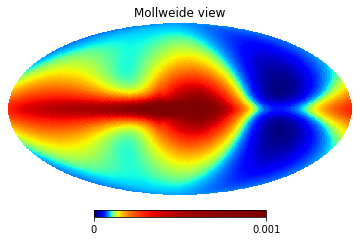

In [5]:
unmasked = maps[('sync','23','32','I')].data

matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
hp.mollview(unmasked[0], norm='hist', cmap='jet', sub=(1,2,1), min=0, max=1.0e-3)

then apply the mask defined in the beginning, **only** to intensity map as defined

<span style="color:red">**apply_mask function will not act twice to the same map**</span>

check closely to the following printing info, the Nside attribute value of masked has been changed to Npix

and, consequently, the HEALPix map has been re-registered as a plain data

dict_keys([('fd', 'nan', '16', 'nan'), ('dm', 'nan', '8', 'nan'), ('sync', '23', '4941', 'I')])


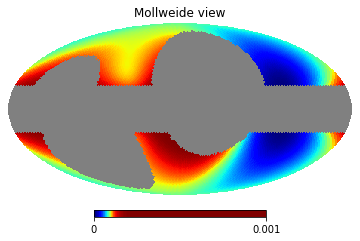

In [6]:
maps.apply_mask(msk_dict)

print (maps.keys())

raw_map = maps[('sync','23','4941','I')].data

masked = np.zeros(hp.nside2npix(mask_nside))

idx = int(0)
for i in range(len(mask_map)):
    if mask_map[i] == 0:
        masked[i] = hp.UNSEEN
    else:
        masked[i] = raw_map[0,idx]
        idx += int(1)

matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
hp.mollview(masked, norm='hist', cmap='jet', sub=(1,2,1), min=0, max=1.0e-3)

# correctness check
for i in range(len(masked)):
    if mask_map[i] == 1 and masked[i] - unmasked[0][i] != 0:
        print ('incorrect mask')

### Using mask in (hammurabi X) simulation
It is also possible to use prepared mask in hammurabi X simulation phase, for saving computing time!
But note that there is only a single mask input entry for hammurabi X, which means all outputs will be masked by the same mask. And the input mask will be treated at pivot resolution, output maps may be in various resolutions by adjusting the input mask into corresponding resolution. It is not trivial in changing mask resolution, for more details please check the hammurabi X wiki.

In [7]:
# push the mask to hammurabi X required format: np.float64, binary file
mask_map.tofile('./mask_tutorial04.bin')
simer._ham.mod_par(['mask'],{'cue':'1','filename':'mask_tutorial04.bin','nside':str(mask_nside)})

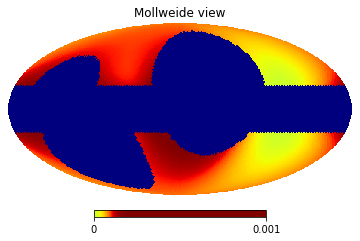

In [8]:
# push fields to simulator
simer.register_fields([breg_lsa, cre_ana, tereg_ymw16])
maps = simer([breg_lsa, cre_ana, tereg_ymw16])

unmasked = maps[('sync','23','32','I')].data

matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
hp.mollview(unmasked[0], norm='hist', cmap='jet', sub=(1,2,1), min=0, max=1.0e-3)

### This ends tutorial 4

See more examples in the *imagine/examples* directory